# k-최근접 이웃 (k-Nearest Neighbor, kNN) 실습

이번 워크시트(출력 결과 및 워크시트 외부의 보조 코드 포함)를 완성한 후 과제 제출 시 함께 제출하세요.
kNN 분류기는 두 단계로 구성됩니다:
  - 훈련(Training) 단계: 분류기는 훈련 데이터를 받아 그대로 저장합니다.
  - 테스트(Testing) 단계: kNN은 모든 테스트 이미지를 모든 훈련 이미지와 비교하고, 가장 유사한 훈련 예제 k개의 라벨을 가져와 분류합니다.
- k 값은 교차 검증(Cross-Validation)을 통해 결정됩니다.

이번 실습에서는 다음을 구현하게 됩니다:
  - 위 단계를 코드로 직접 작성
  - 기본적인 이미지 분류 파이프라인 이해
  - 교차 검증 활용
  - 효율적인 벡터화(Vectorized) 코드 작성 능력 습득


In [7]:
# 필요한 library import
import random
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

# matplotlib settting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load dataset
import numpy as np
from torchvision import datasets, transforms

def load_CIFAR10(num_train=5000, num_test=500):
    transform = transforms.Compose([transforms.ToTensor()])

    trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    # numpy 변환 + float64 캐스팅
    X_train = trainset.data[:num_train].astype(np.float64).reshape(num_train, -1)
    y_train = np.array(trainset.targets[:num_train])

    X_test = testset.data[:num_test].astype(np.float64).reshape(num_test, -1)
    y_test = np.array(testset.targets[:num_test])

    return X_train, y_train, X_test, y_test

In [9]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/home/didimdol/cifar-10'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(num_train=5000, num_test=500)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (5000, 3072)
Training labels shape:  (5000,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)


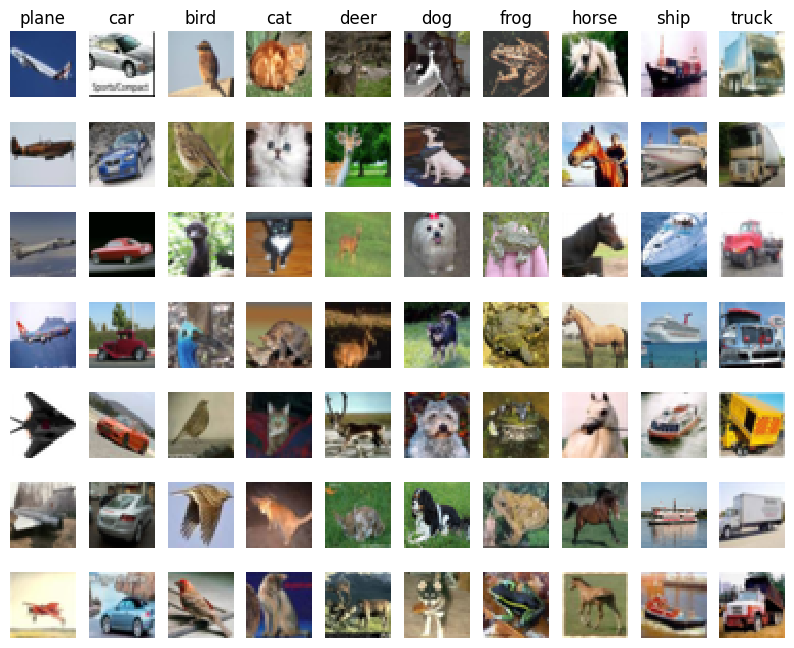

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(32, 32, 3).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [12]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [13]:
from k_nn import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


# k-최근접 이웃 (k-Nearest Neighbor, kNN) - 거리 계산

테스트 데이터를 kNN 분류기로 분류하는 과정은 두 단계로 나눌 수 있습니다:

1. 모든 테스트 샘플과 모든 학습 샘플 사이의 **거리(Euclidean distance)** 계산  
2. 계산된 거리로부터 각 테스트 샘플에 대해 k개의 최근접 이웃을 찾고, 그들의 투표로 라벨 결정  

---

## 거리 행렬 (Distance Matrix)

- 학습 샘플 수: **Ntr**  
- 테스트 샘플 수: **Nte**  
- 결과 행렬 크기: **Nte × Ntr**  
  - 행렬의 원소 $(i, j)$는 $i$번째 테스트 샘플과 j번째 학습 샘플 사이의 거리  

---

## 유클리드 거리 정의

두 벡터 $(x \in \mathbb{R}^d)$, $(y \in \mathbb{R}^d)$ 사이의 유클리드 거리는 다음과 같습니다:

$$
d(x, y) = \sqrt{\sum_{k=1}^{d} (x_k - y_k)^2}
$$

- 각 차원별 차이를 제곱한 뒤 모두 더하고, 제곱근을 취함
- L2-Norm 기반 거리라고도 부름

## Assignment 1
- knn.py 클래스를 보고 함수를 완성시키시오.
- 함수 작성: `compute_distances_two_loops`  
  - **이중 반복문**으로 모든 (테스트, 학습) 샘플 쌍에 대해 거리 계산  
  - 계산 결과를 거리 행렬의 해당 원소에 저장  
- 이 방식은 **매우 비효율적**이나, kNN 거리 계산의 기초를 이해하는 데 적합

## Assignment 2

- knn.py 클래스를 보고 함수를 완성시키시오.

- 함수 작성: `compute_distances_one_loop`

- 단일 반복문으로 각 테스트 샘플과 모든 학습 샘플 간의 거리 계산

- 반복문은 테스트 데이터에 대해서만 수행

- 이 방식은 two_loops보다 효율적이며, 벡터 연산의 활용을 이해하는 단계

## Assignment 3

- knn.py 클래스를 보고 함수를 완성시키시오.

- 함수 작성: `compute_distances_no_loop`

- 반복문 없이 행렬 연산만으로 모든 거리 계산

- 공식: $(x - y)^2 = x^2 + y^2 - 2xy$ 활용

- 이 방식은 가장 효율적이며, kNN 구현의 최적화된 형태

In [14]:
# Test your implementation:
dists = classifier.compute_distances_no_loops(X_test)
print(dists.shape)

(500, 5000)


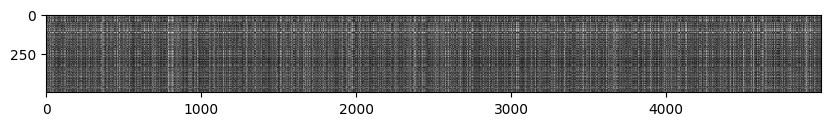

In [15]:
# 각 행은 하나의 테스트 예제이고, 그 행의 값들은 해당 테스트 예제와 학습 예제들 사이의 거리이다.
plt.imshow(dists, interpolation='none')
plt.show()

## Assignment 4 : 거리 행렬에서 구조적인 패턴을 보라. 몇몇 행이나 열이 눈에 띄게 더 밝게 보인다. (기본 색상 체계에서 검정은 작은 거리, 흰색은 큰 거리를 의미함.)

뚜렷하게 밝은 행들은 데이터에서 무엇 때문에 생기는가?

뚜렷하게 밝은 열들은 무엇 때문에 생기는가?

**Your Answer**: 

밝은 행들은 test set 이미지가 train set중 비슷한 이미지가 없어서 계산된 거리값이 큼을 의미하고, 밝은 열들은 반대로 train set 이미지가 test set중 비슷한 이미지가 없어서 계산된 거리 값이 큼을 의미한다.


In [16]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


# Assignment 5 : 여러 $k$ 실험
대략 27% 정확도를 기대할 수 있다. $k$를 1부터 5까지 조절해가면서 정확도를 찍어보시오.

In [17]:
# k = 1
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [18]:
# k = 2
y_test_pred = classifier.predict_labels(dists, k=2)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 112 / 500 correct => accuracy: 0.224000


In [19]:
# k = 3
y_test_pred = classifier.predict_labels(dists, k=3)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 136 / 500 correct => accuracy: 0.272000


In [20]:
# k = 4
y_test_pred = classifier.predict_labels(dists, k=4)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 136 / 500 correct => accuracy: 0.272000


In [21]:
# k = 5
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


**$k$값이 몇일 때, 가장 정확도가 큰지 작성하시오.**

**Your Answer**:  k = 5 일때 0.278000으로 가장 정확했다.

# Assignment 6  
우리는 또한 L1 거리와 같은 다른 거리 척도를 사용할 수 있다.  
L1 거리를 사용하는 최근접 이웃 분류기의 성능은 다음 경우에 변하지 않는다 (해당되는 모든 것을 고르시오):  
1. 데이터에서 평균을 빼서 전처리한 경우.  
2. 데이터에서 평균을 빼고 표준편차로 나누어 전처리한 경우.  
3. 데이터의 좌표축을 회전시킨 경우.  
4. 위의 어느 것도 아님.  

*Your answer :*  [1, 2번]
1번의 경우 데이터의 평균은 상수 취급해도 되기 때문에 변하지 않는다.
2번의 경우 평균은 1번 답처럼 상수취급되고, 표준편차 또한 모든 데이터에 대해 동일하므로 상대적인 L1값을 바꾸지는 않는다.
3번의 경우 좌표계를 회전시키면 L1값이 변하기 때문에 성능 변화가 있다.


In [22]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [23]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [24]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 22.764824 seconds
One loop version took 48.043023 seconds
No loop version took 0.259021 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [25]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # prepare training data for the current fold
        X_train_fold = np.concatenate([ fold for j, fold in enumerate(X_train_folds) if i != j ])
        y_train_fold = np.concatenate([ fold for j, fold in enumerate(y_train_folds) if i != j ])
        
        # use of k-nearest-neighbor algorithm
        classifier.train(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=0)

        # Compute the fraction of correctly predicted examples
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        accuracy = float(num_correct) / X_train_folds[i].shape[0]
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

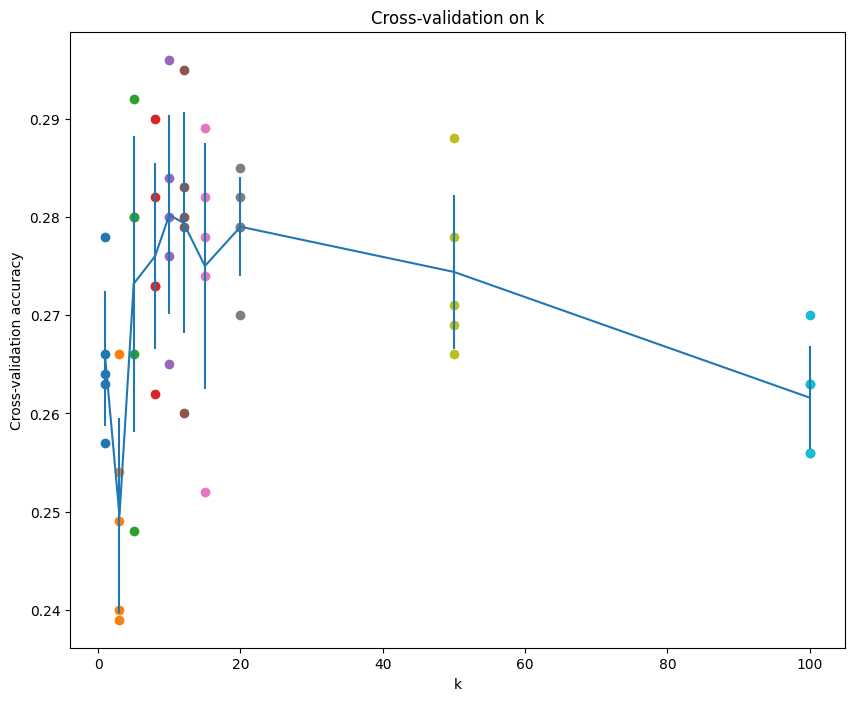

In [26]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [27]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


## Assignment  8
분류 환경에서 $k$-최근접 이웃(k-NN)에 대한 다음 설명 중, 모든 $k$에 대해 참인 것은 무엇인가?
해당되는 항목을 모두 고르고, 각 항목당 선택한 이유를 작성하시오.

1. 1-NN의 학습 오류는 항상 5-NN의 학습 오류보다 더 낫(x)낮다.  
2. 1-NN의 테스트 오류는 항상 5-NN의 테스트 오류보다 더 낫(x)낮다.  
3. k-NN 분류기의 결정 경계는 선형이다.  
4. k-NN 분류기로 테스트 예제를 분류하는 데 걸리는 시간은 훈련 집합의 크기에 비례하여 증가한다.  
5. 위의 어느 것도 아님.  

*Your answer :* [1, 4번]
1번의 경우, 1-NN의 경우 가장 가까운 이웃은 항상 자기 자신이므로 오차가 0일 수 밖에 없다. 따라서 1-NN의 오류가 항상 더 낮다.
2번의 경우, Cross_validation 결과를 보았을 때, 1-NN의 성능이더 높은 경우도 있었다.
3번의 경우 거리를 기준으로 분류를 하기 때문에 선형적으로 분류되지 않는다.
4번의 경우, 이미지를 하나하나 분류하기 떄문에 시간은 집합의 크기에 비례하여 증가한다.